# Dataset and Other Requirements loading

In [7]:
import pandas as pd
import numpy as np
import re
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
!git clone https://github.com/gorilla15a/Autojudge-Problem-Difficulty-Predictor


Cloning into 'Autojudge-Problem-Difficulty-Predictor'...
Updating files:  50% (6/12)
Updating files:  58% (7/12)
Updating files:  66% (8/12)
Updating files:  75% (9/12)
Updating files:  83% (10/12)
Updating files:  91% (11/12)
Updating files: 100% (12/12)
Updating files: 100% (12/12), done.
Filtering content: 100% (1/1)
Filtering content: 100% (1/1), 19.35 MiB | 1.35 MiB/s, done.


In [9]:
df=pd.read_json("Autojudge-Problem-Difficulty-Predictor/problems_data.jsonl",lines=True,encoding='utf-8')

# EDA & Preprocessing

In [10]:
df.shape

(4112, 8)

In [11]:
df.columns

Index(['title', 'description', 'input_description', 'output_description',
       'sample_io', 'problem_class', 'problem_score', 'url'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               4112 non-null   object 
 1   description         4112 non-null   object 
 2   input_description   4112 non-null   object 
 3   output_description  4112 non-null   object 
 4   sample_io           4112 non-null   object 
 5   problem_class       4112 non-null   object 
 6   problem_score       4112 non-null   float64
 7   url                 4112 non-null   object 
dtypes: float64(1), object(7)
memory usage: 257.1+ KB


No Null rows

In [13]:
df['problem_score'].value_counts().sort_index()

problem_score
1.1     9
1.2    21
1.3    29
1.4    36
1.5    64
       ..
9.3    14
9.4    13
9.5     7
9.6     5
9.7     2
Name: count, Length: 87, dtype: int64

Problem Score ranges from 1.1 to 9.7

In [14]:
df['problem_class'].value_counts()

problem_class
hard      1941
medium    1405
easy       766
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Problem Classes')

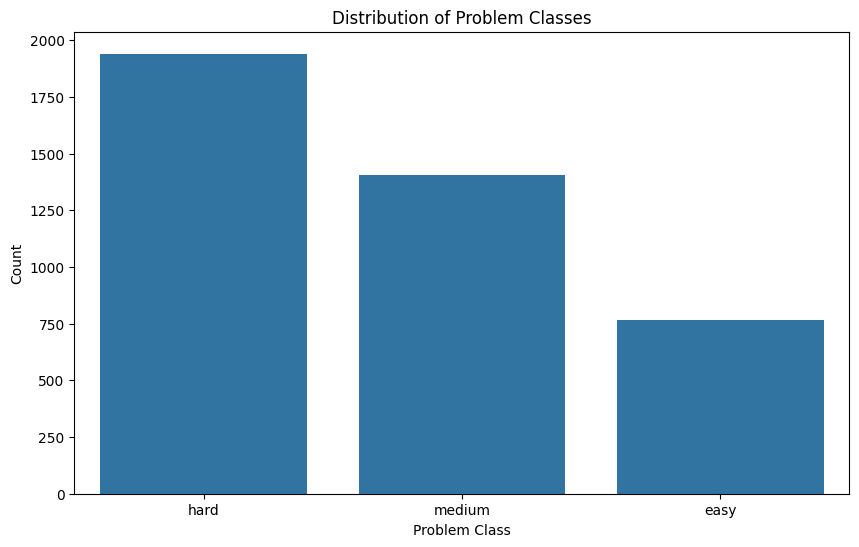

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='problem_class')
plt.xlabel('Problem Class')
plt.ylabel('Count')
plt.title('Distribution of Problem Classes')

In [16]:
df['sample_io'].value_counts()

sample_io
[]                                                                                                                                                                                                                                                                                                                                 30
[{'input': '', 'output': ''}]                                                                                                                                                                                                                                                                                                      24
[{'input': '', 'output': ''}, {'input': '', 'output': ''}]                                                                                                                                                                                                                                                                         17
[{'input': '

Sample_input and Sample_output usually contain an array of numbers and brackets

In [17]:
print("Total samples:", len(df))
print("\nMissing values per column:\n", df.isnull().sum())

Total samples: 4112

Missing values per column:
 title                 0
description           0
input_description     0
output_description    0
sample_io             0
problem_class         0
problem_score         0
url                   0
dtype: int64


In [18]:
import pandas as pd
import re
def clean_text(text):
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return ""
    if isinstance(text, (list, dict)):
        text = str(text)
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)

    return text.strip()


In [19]:
text_cols = [
    'title',
    'description',
    'input_description',
    'output_description'
]
for col in text_cols:
    df[col] = df[col].apply(clean_text)

In [20]:
df['full_text'] = (
    df['title'] + " " +
    df['description'] + " " +
    df['input_description'] + " " +
    df['output_description']
)

In [21]:
df['full_text'].iloc[0][:]


'uuu unununium (uuu) was the name of the chemical element with atom number 111, until it changed to röntgenium (rg) in 2004. these heavy elements are very unstable and have only been synthesized in a few laboratories. you have just been hired by one of these labs to optimize the algorithms used in simulations. for example, when simulating complicated chemical reactions, it is important to keep track of how many particles there are, and this is done by counting connected components in a graph. currently, the lab has some python code (see attachments) that takes an undirected graph and outputs the number of connected components. as you can see, this code is based on everyone’s favourite data structure union-find1. after looking at the code for a while, you notice that it actually has a bug in it! the code still gives correct answers, but the bug could cause it to run inefficiently. your task is to construct a graph with a given number of vertices and edges where the code runs very slowly

In [22]:
X_text = df['full_text']
y_class = df['problem_class']
y_score = df['problem_score']

In [23]:
df[['full_text', 'problem_class', 'problem_score']].to_csv(
    "processed_problems_data.csv",
    index=False)

In [24]:
def extract_structural_features(sample_io):
    text = str(sample_io)
    numbers = re.findall(r'-?\d+', text)
    num_numbers = len(numbers)

    max_num_length = max([len(n) for n in numbers], default=0)

    num_lines = text.count('\n') + 1 if text.strip() else 0

    num_brackets = sum(text.count(b) for b in ['[', ']', '{', '}', '(', ')'])

    has_matrix_like = int(
        ('[' in text and ']' in text and ',' in text and '\n' in text)
    )

    return [
        num_numbers,
        num_lines,
        num_brackets,
        max_num_length,
        has_matrix_like
    ]

structural_features = df.apply(
    lambda row: extract_structural_features(
        row["sample_io"]
    ),
    axis=1,
    result_type="expand"
)
structural_features.columns = [
    "num_numbers",
    "num_lines",
    "num_brackets",
    "max_num_length",
    "has_matrix_like"
]

df = pd.concat([df, structural_features], axis=1)

In [25]:
df.head()

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url,full_text,num_numbers,num_lines,num_brackets,max_num_length,has_matrix_like
0,uuu,unununium (uuu) was the name of the chemical e...,the input consists of one line with two intege...,the output consists of $m$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu,uuu unununium (uuu) was the name of the chemic...,22,1,4,2,0
1,house building,a number of eccentrics from central new york h...,"the input consists of $10$ test cases, which a...",print $k$ lines with the positions of the hous...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge,house building a number of eccentrics from cen...,14,1,4,2,0
2,mario or luigi,mario and luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi,mario or luigi mario and luigi are playing a g...,0,1,4,0,0
3,the wire ghost,žofka is bending a copper wire. she starts wit...,the first line contains two integers $l$ and $...,the output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost,the wire ghost žofka is bending a copper wire....,10,1,6,1,0
4,barking up the wrong tree,"your dog spot is let loose in the park. well, ...",the first line of input consists of two intege...,write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree,barking up the wrong tree your dog spot is let...,18,1,6,2,0


# Feature Engineering

In [26]:
from sklearn.model_selection import train_test_split
X = df['full_text']
y_class = df['problem_class']
y_score = df['problem_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)
df_train=df.loc[X_train.index]
df_test=df.loc[X_test.index]

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 1),
    min_df=3,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [28]:
import numpy as np
math_symbols = ['+', '-', '*', '/', '%', '<', '>', '=', '^']
keywords = ['graph', 'dp', 'dynamic programming', 'recursion',
            'optimize', 'complexity', 'tree', 'greedy']

def count_math_symbols(text):
    return sum(text.count(sym) for sym in math_symbols)

def keyword_frequency(text):
    return sum(text.count(k) for k in keywords)

def semantic_features(text_series):
    return np.column_stack([
        text_series.apply(len),
        text_series.apply(count_math_symbols),
        text_series.apply(keyword_frequency)
    ])

In [29]:
def engineered_features(X_text, df_subset):
    sem_feats = np.column_stack([
        X_text.apply(len),
        X_text.apply(count_math_symbols),
        X_text.apply(keyword_frequency)
    ])

    struct_feats = np.vstack(
    df_subset["sample_io"].apply(extract_structural_features).to_numpy()
)


    # FINAL engineered matrix → 3 + 5 = 8 features
    return np.hstack([sem_feats, struct_feats])


In [30]:
X_train_engineered = engineered_features(X_train,df_train)
X_test_engineered = engineered_features(X_test,df_test)

In [31]:
print(X_train_engineered.shape)
print(X_test_engineered.shape)


(3289, 8)
(823, 8)


In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_engineered_scaled = scaler.fit_transform(X_train_engineered)
X_test_engineered_scaled  = scaler.transform(X_test_engineered)


In [35]:
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']

In [36]:
print("Scaler expects:", scaler.n_features_in_)

Scaler expects: 8


In [37]:
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf, X_train_engineered])
X_test_combined = hstack([X_test_tfidf, X_test_engineered])

# Classification Model

In [41]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

d:\Ansul\data\New folder\autojudge\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.44835965978128794
              precision    recall  f1-score   support

        easy       0.37      0.52      0.43       153
        hard       0.59      0.43      0.50       389
      medium       0.38      0.43      0.40       281

    accuracy                           0.45       823
   macro avg       0.44      0.46      0.44       823
weighted avg       0.48      0.45      0.45       823



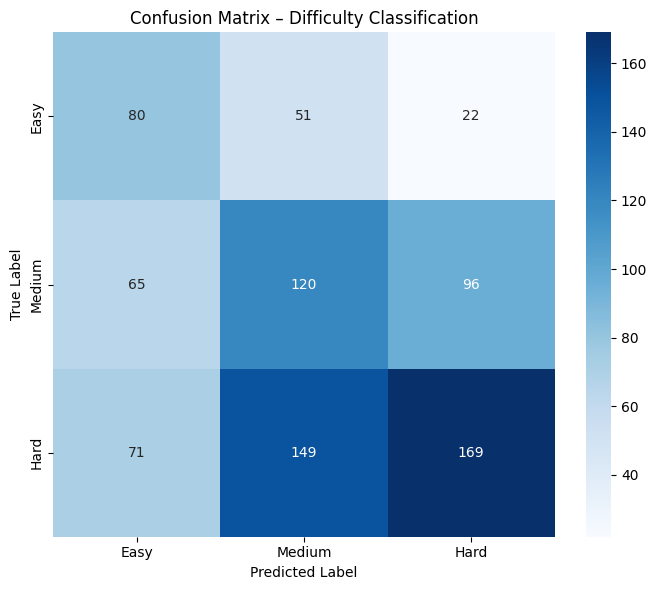

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    C=2.0,
    solver='lbfgs'
)

logreg.fit(X_train_combined, y_train)

y_pred_lr = logreg.predict(X_test_combined)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
labels = ["easy", "medium", "hard"]
cm = confusion_matrix(y_test, y_pred_lr, labels=labels)
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[label.capitalize() for label in labels],
    yticklabels=[label.capitalize() for label in labels]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Difficulty Classification")

plt.tight_layout()
plt.show()

SVM

d:\Ansul\data\New folder\autojudge\venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM Accuracy: 0.48116646415552855
              precision    recall  f1-score   support

        easy       0.39      0.33      0.36       153
        hard       0.54      0.69      0.61       389
      medium       0.40      0.27      0.32       281

    accuracy                           0.48       823
   macro avg       0.44      0.43      0.43       823
weighted avg       0.46      0.48      0.46       823



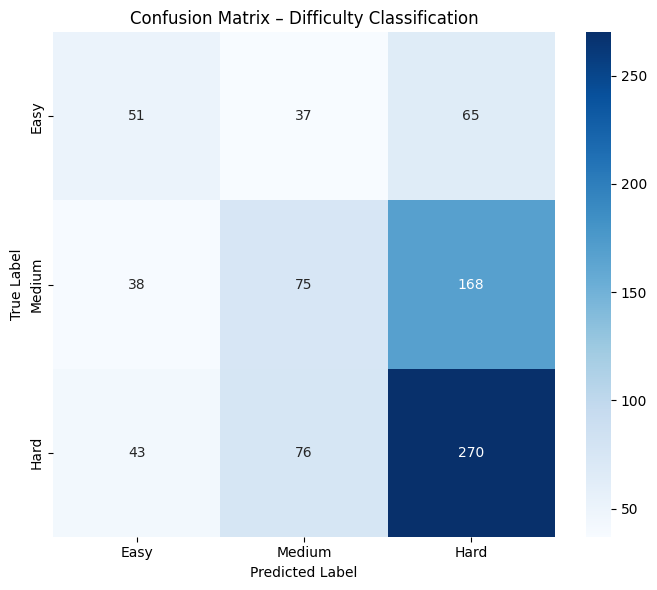

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC(
    C=0.3,
    max_iter=20000,
    tol=1e-3
)
#svm.fit(X_train_tfidf, y_train)
#y_pred = svm.predict(X_test_tfidf)
svm.fit(X_train_combined, y_train)
y_pred = svm.predict(X_test_combined)
from sklearn.metrics import accuracy_score, classification_report
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
labels = ["easy", "medium", "hard"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[label.capitalize() for label in labels],
    yticklabels=[label.capitalize() for label in labels]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Difficulty Classification")

plt.tight_layout()
plt.show()


Random Forest Implementation

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_rf = TfidfVectorizer(
    max_features=1000,
    min_df=5,
    stop_words='english'
)

X_train_tfidf_rf = tfidf_rf.fit_transform(X_train).toarray()
X_test_tfidf_rf = tfidf_rf.transform(X_test).toarray()

In [39]:
X_train_rf = np.hstack([X_train_tfidf_rf, X_train_engineered_scaled])
X_test_rf = np.hstack([X_test_tfidf_rf, X_test_engineered_scaled])

Random Forest Accuracy: 0.5309842041312273
              precision    recall  f1-score   support

        easy       0.45      0.42      0.44       153
        hard       0.58      0.81      0.68       389
      medium       0.41      0.20      0.27       281

    accuracy                           0.53       823
   macro avg       0.48      0.48      0.46       823
weighted avg       0.50      0.53      0.49       823



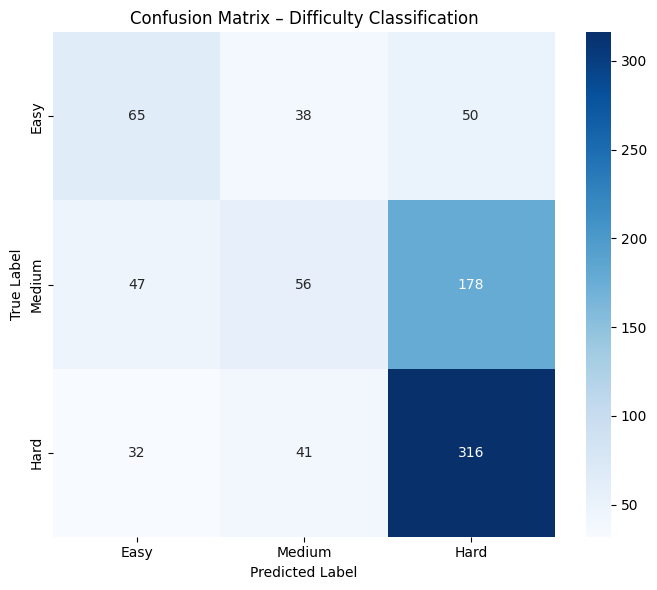

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_rf, y_train)

y_pred_rf = rf.predict(X_test_rf)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
labels = ["easy", "medium", "hard"]
cm = confusion_matrix(y_test, y_pred_rf, labels=labels)
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[label.capitalize() for label in labels],
    yticklabels=[label.capitalize() for label in labels]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Difficulty Classification")

plt.tight_layout()
plt.show()


# Regression Model

In [43]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    df['full_text'],
    y_score,
    test_size=0.2,
    random_state=42
)

In [44]:
tfidf_rg = TfidfVectorizer(
    max_features=3000,
    min_df=3,
    stop_words='english'
)

X_train_tfidf_rg = tfidf_rg.fit_transform(X_train)
X_test_tfidf_rg = tfidf_rg.transform(X_test)


In [45]:
def engineered_features(X_text, df_subset):
    sem_feats = np.column_stack([
        X_text.apply(len),
        X_text.apply(count_math_symbols),
        X_text.apply(keyword_frequency)
    ])

    struct_feats = np.vstack(
        df_subset["sample_io"].apply(extract_structural_features).to_numpy()
    )

    return np.hstack([sem_feats, struct_feats])



In [46]:
X_train_engineered = engineered_features(X_train, df_train)
X_test_engineered = engineered_features(X_test, df_test)


In [47]:
print(X_train_engineered.shape)  # (n_train, 8)
print(X_test_engineered.shape)   # (n_test, 8)


(3289, 8)
(823, 8)


In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_engineered_scaled = scaler.fit_transform(X_train_engineered)
X_test_engineered_scaled = scaler.transform(X_test_engineered)
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']

In [49]:
X_train_reg = hstack([X_train_tfidf_rg, X_train_engineered_scaled])
X_test_reg = hstack([X_test_tfidf_rg, X_test_engineered_scaled])

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)

y_pred_lr = lr.predict(X_test_reg)

print("Linear Regression MAE:", mean_absolute_error(y_test_reg, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)))


Linear Regression MAE: 5.247318164914233
Linear Regression RMSE: 6.840915264460398


In [51]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train_reg.toarray(), y_train_reg)

y_pred_rf = rf_reg.predict(X_test_reg.toarray())

print("Random Forest MAE:", mean_absolute_error(y_test_reg, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_rf)))


Random Forest MAE: 1.710042519125868
Random Forest RMSE: 2.0506899051467267


In [52]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gb_reg.fit(X_train_reg.toarray(), y_train_reg)

y_pred_gb = gb_reg.predict(X_test_reg.toarray())

print("Gradient Boosting MAE:", mean_absolute_error(y_test_reg, y_pred_gb))
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_gb)))
print("Gradient Boosting R2 Score:", gb_reg.score(X_test_reg.toarray(), y_test_reg))

Gradient Boosting MAE: 1.6933092417895048
Gradient Boosting RMSE: 2.0348564071782165
Gradient Boosting R2 Score: 0.13741051026648154


In [53]:
joblib.dump(tfidf_rf, "../models/tfidf_classifier.pkl")
joblib.dump(rf, "../models/rf.pkl")
joblib.dump(gb_reg, "../models/gb_regressor.pkl")
joblib.dump(tfidf_rg, "../models/tfidf_regressor.pkl")

['../models/tfidf_regressor.pkl']

Considering the confusion matrix it was appropriate to see what range of problem score falls in problem class so as to decide a threshold

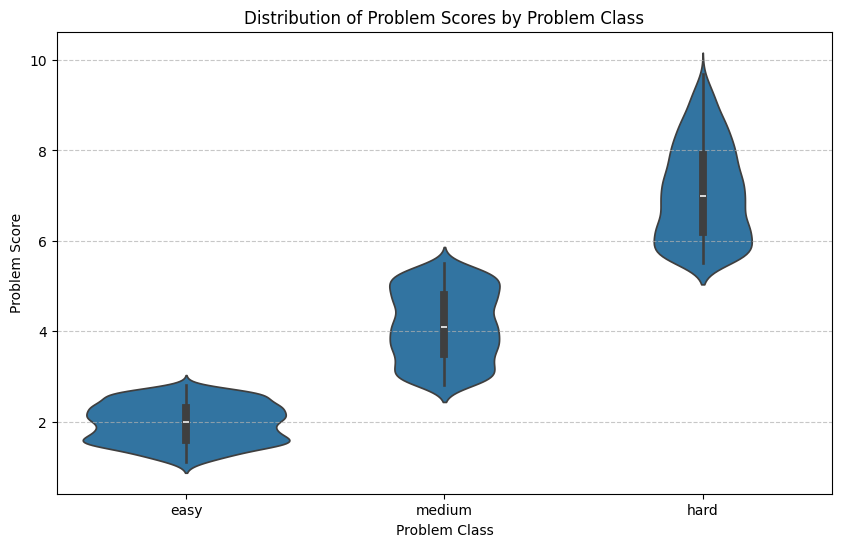

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(x='problem_class', y='problem_score', data=df, order=['easy', 'medium', 'hard'])
plt.title('Distribution of Problem Scores by Problem Class')
plt.xlabel('Problem Class')
plt.ylabel('Problem Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This violin plot illustrates:

*   **Central Tendency:** The thick bar in the middle of each violin represents the interquartile range, and the white dot indicates the median problem score for that class.
*   **Distribution Shape:** The width of the violin at any given point indicates the density of problems at that score. For example, a wider section means more problems fall within that score range. Here it is clear that for easy majority lies in around 2 to 3 but there an intersection with the medium range where the number of easy are ofcourse more but it explains why some of the classification model misinterpreted mediums as easy and vice versa same goes for hard and medium.
*   **Score Range:** The total vertical extent of each violin shows the full range of problem scores for that class.

From this, we can see the typical score ranges for 'easy', 'medium', and 'hard' problems, and how much overlap there is between these categories.

In [ ]:
easy_max = df[df["problem_class"] == "easy"]["problem_score"].quantile(0.75)
medium_min = df[df["problem_class"] == "medium"]["problem_score"].quantile(0.25)
medium_max = df[df["problem_class"] == "medium"]["problem_score"].quantile(0.75)
hard_min = df[df["problem_class"] == "hard"]["problem_score"].quantile(0.25)

print("Easy upper bound:", easy_max)
print("Medium lower bound:", medium_min)
print("Medium upper bound:", medium_max)
print("Hard lower bound:", hard_min)


Easy upper bound: 2.3
Medium lower bound: 3.5
Medium upper bound: 4.8
Hard lower bound: 6.2


In [ ]:
EASY_THRESHOLD = easy_max
HARD_THRESHOLD = hard_min

In [ ]:
def score_based_class(score):
    if score < EASY_THRESHOLD:
        return "easy"
    elif score >= HARD_THRESHOLD:
        return "hard"
    else:
        return "medium"

y_pred_score_based = y_test_reg.apply(score_based_class)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_score_based))
print(confusion_matrix(y_test, y_pred_score_based))


              precision    recall  f1-score   support

        easy       0.22      0.13      0.16       153
        hard       0.48      0.40      0.43       389
      medium       0.34      0.49      0.40       281

    accuracy                           0.38       823
   macro avg       0.34      0.34      0.33       823
weighted avg       0.38      0.38      0.37       823

[[ 20  55  78]
 [ 43 155 191]
 [ 29 115 137]]


Hence problem score based class prediction have lower accuracy when comapred to the supervised classification model so this is not a good measure.

In [ ]:
clf_preds = rf.predict(X_test_rf)
reg_scores = gb_reg.predict(X_test_reg.toarray())

In [ ]:
def hybrid_decision(clf_pred, reg_score):
    if clf_pred == "medium" and reg_score >= HARD_THRESHOLD:
        return "hard"
    elif clf_pred == "hard" and reg_score < HARD_THRESHOLD:
        return "medium"
    elif clf_pred == "easy" and reg_score >= EASY_THRESHOLD:
        return "medium"
    else:
        return clf_pred

hybrid_preds = [
    hybrid_decision(c, s)
    for c, s in zip(clf_preds, reg_scores)
]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, hybrid_preds))


              precision    recall  f1-score   support

        easy       0.00      0.00      0.00       153
        hard       0.48      0.03      0.06       389
      medium       0.34      0.97      0.51       281

    accuracy                           0.35       823
   macro avg       0.27      0.33      0.19       823
weighted avg       0.34      0.35      0.20       823



d:\Ansul\data\New folder\autojudge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Ansul\data\New folder\autojudge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Ansul\data\New folder\autojudge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

This shows that its overding majority values leading to bad predictions so we stick with random classifier for classifcation and gradient boosting regressor for predicitng problem scores.